In [14]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import xarray as xr
import os
import glob
import datetime
import matplotlib.pyplot as plt
from functions import preproc_nemo
from functions import yearFraction
from functions import remove_seasonal_cycle
expname='alfa'
expdir=os.path.join('/ec/res4/scratch/itas/ece4/', expname, 'output', 'nemo')

In [2]:
domain = xr.open_dataset(os.path.join(expdir, '..', '..', 'domain_cfg.nc'))
vol = domain['e1t']*domain['e2t']*domain['e3t_0']
area = domain['e1t']*domain['e2t']
sect = domain['e2t']*domain['e3t_0']
dz = domain['e3t_0']

In [3]:
start_year = 1990
end_year = 2010

# Generate a list of file paths that match the specified year range
filelist = []
for year in range(start_year, end_year + 1):
    pattern = os.path.join(expdir, f"{expname}_oce_1m_T_{year}-{year}.nc")
    matching_files = glob.glob(pattern)
    filelist.extend(matching_files)
data = xr.open_mfdataset(filelist, preprocess=preproc_nemo)
#filelist = glob.glob(os.path.join(expdir, expname + '_oce_1m_T_*.nc'))
#data = xr.open_mfdataset(filelist, preprocess=preproc_nemo)
data

<xarray.Dataset>
Dimensions:               (y: 331, x: 360, z: 75, time: 252, axis_nbounds: 2)
Coordinates:
    nav_lat_grid_T        (y, x) float32 dask.array<chunksize=(331, 360), meta=np.ndarray>
    nav_lon_grid_T        (y, x) float32 dask.array<chunksize=(331, 360), meta=np.ndarray>
  * z                     (z) float32 0.5 1.55 2.661 ... 5.698e+03 5.902e+03
    time_centered         (time) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
  * time                  (time) datetime64[ns] 1990-01-16T12:00:00 ... 2010-...
Dimensions without coordinates: y, x, axis_nbounds
Data variables: (12/25)
    deptht_bounds         (time, z, axis_nbounds) float32 dask.array<chunksize=(12, 75, 2), meta=np.ndarray>
    time_centered_bounds  (time, axis_nbounds) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
    time_counter_bounds   (time, axis_nbounds) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
    e3t                   (time, z, y, x) float32 dask.array<chunksize=(1, 75, 331, 360), meta=np.ndarray>
    thetao                (time, z, y, x) float32 dask.array<chunksize=(1, 75, 331, 360), meta=np.ndarray>
    so                    (time, z, y, x) float32 dask.array<chunksize=(1, 75, 331, 360), meta=np.ndarray>
    ...                    ...
    qt_oce                (time, y, x) float32 dask.array<chunksize=(1, 331, 360), meta=np.ndarray>
    sfx                   (time, y, x) float32 dask.array<chunksize=(1, 331, 360), meta=np.ndarray>
    taum                  (time, y, x) float32 dask.array<chunksize=(1, 331, 360), meta=np.ndarray>
    windsp                (time, y, x) float32 dask.array<chunksize=(1, 331, 360), meta=np.ndarray>
    precip                (time, y, x) float32 dask.array<chunksize=(1, 331, 360), meta=np.ndarray>
    snowpre               (time, y, x) float32 dask.array<chunksize=(1, 331, 360), meta=np.ndarray>
Attributes:
    name:         output/nemo/alfa_oce_1m_T
    description:  ECE4/NEMO T grid variables
    title:        ECE4/NEMO T grid variables
    Conventions:  CF-1.6
    timeStamp:    2023-Oct-13 11:38:45 GMT
    uuid:         e21bf71b-a31b-4665-8d7d-ae7805fcdfa1

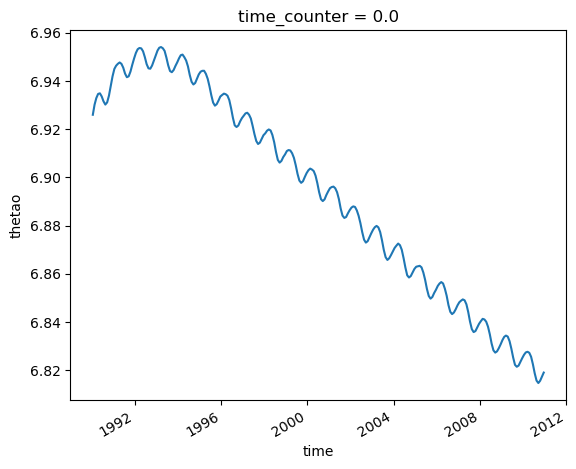

In [4]:
out_global_temp = data.thetao.weighted(vol).mean(dim=['z', 'y', 'x']).plot()

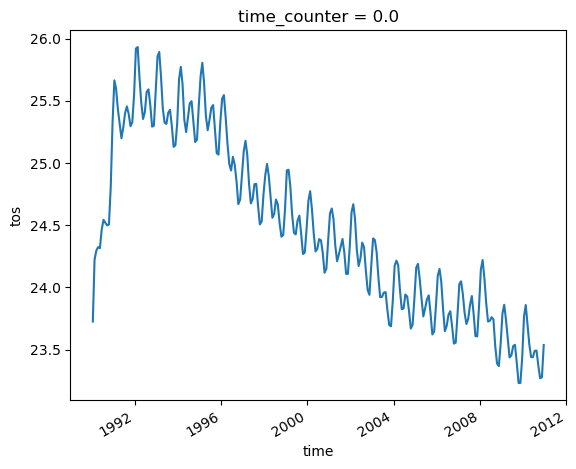

In [5]:
out_sst = data.tos.weighted(area).mean(dim=['y', 'x']).plot()

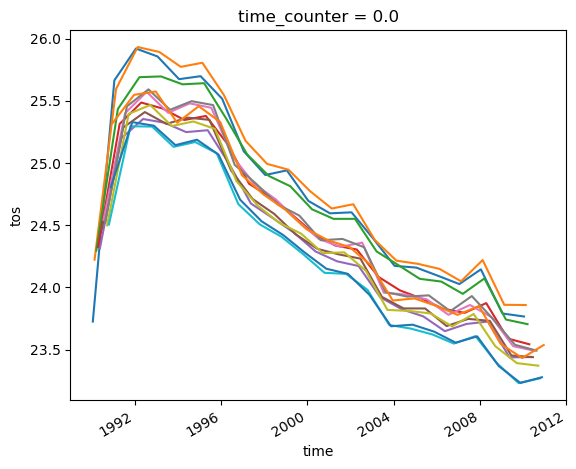

In [6]:
for tm in range(12):
    data.where(data['time.month']==tm+1,drop=True).tos.weighted(area).mean(dim=['y', 'x']).plot()

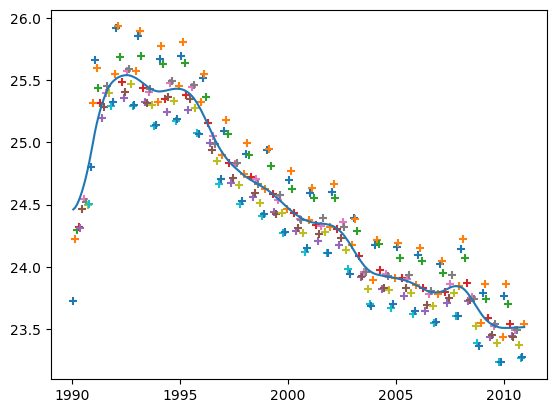

In [7]:
xdata = data.time
ydata = data.tos.weighted(area).mean(dim=['y', 'x'])
for tm in range(12):
    d1 = pd.to_datetime(xdata.values)
    x1 = [yearFraction(t) for t in d1]
    d0 = pd.to_datetime(xdata.where(data['time.month']==tm+1,drop=True).values)
    x0 = [yearFraction(t) for t in d0]
    y0 = ydata.where(data['time.month']==tm+1,drop=True).values
    x1 = np.array(x1)
    x0 = np.array(x0)
    y0 = np.array(y0.flatten())
    if (tm==0):
        y1 = np.interp(x1, x0, y0)
    else:
        y1 = y1 + np.interp(x1, x0, y0)
    plt.scatter(x0,y0,marker='+')
y1 = y1/12
plt.plot(x1,y1)
# average
#y2 = data.tos.weighted(area).mean(dim=['y', 'x']).values
#plt.plot(x1,y2)

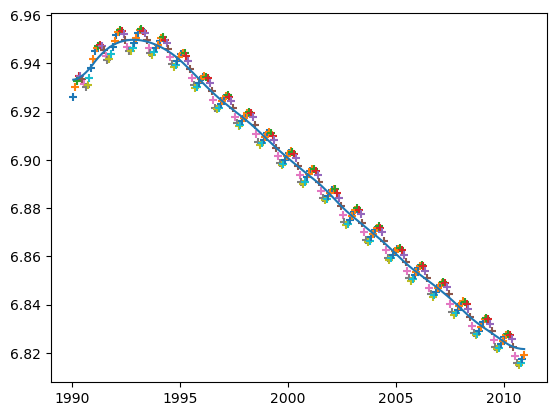

In [8]:
for tm in range(12):
    d1 = pd.to_datetime(data.time.values)
    x1 = [yearFraction(t) for t in d1]
    d0 = pd.to_datetime(data.where(data['time.month']==tm+1,drop=True).time.values)
    x0 = [yearFraction(t) for t in d0]
    y0 = data.where(data['time.month']==tm+1,drop=True).thetao.weighted(vol).mean(dim=['z', 'y', 'x']).values
    x1 = np.array(x1)
    x0 = np.array(x0)
    y0 = np.array(y0.flatten())
    if (tm==0):
        y1 = np.interp(x1, x0, y0)
    else:
        y1 = y1 + np.interp(x1, x0, y0)
    plt.scatter(x0,y0,marker='+')
y1 = y1/12
plt.plot(x1,y1)
# average
#y2 = data.tos.weighted(area).mean(dim=['y', 'x']).values
#plt.plot(x1,y2)

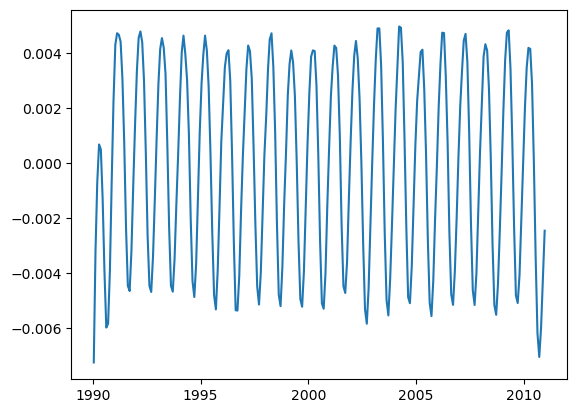

In [9]:
# extract the seasonal component
d1 = pd.to_datetime(data.time.values)
x1 = [yearFraction(t) for t in d1]
y0 = data.thetao.weighted(vol).mean(dim=['z', 'y', 'x']).values
y0 = np.array(y0.flatten())
y2 = y0-y1
plt.plot(x1,y2)

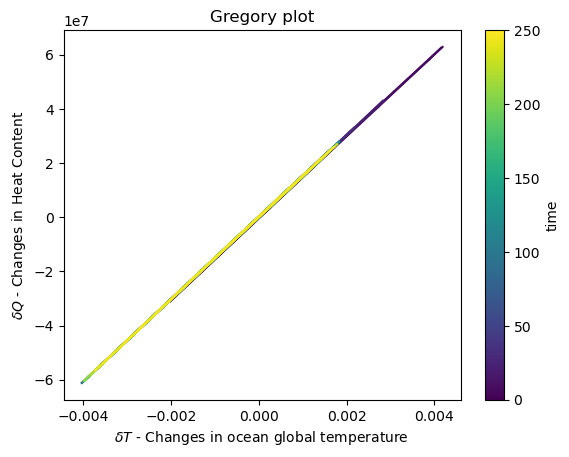

In [10]:
# gregory plot
xg=data.thetao.weighted(vol).mean(dim=['y', 'x', 'z']).values
#xg=data.tos.weighted(area).mean(dim=['y', 'x']).values
yg=data.heatc.weighted(area).mean(dim=['y', 'x']).values
#yg=data.qsr_oce.weighted(area).mean(dim=['y', 'x']).values
xd = []; yd = []
for i in range(len(xg) - 1):
    xd.append(xg[i+1]-xg[i])
    yd.append(yg[i+1]-yg[i])
colormap = plt.get_cmap('viridis')
colors = [colormap(i / (len(xd) - 1)) for i in range(len(xd) - 1)]
fig, ax = plt.subplots()
for i in range(len(xd) - 1):
    ax.plot(xd[i:i+2], yd[i:i+2], color=colors[i])
sm = plt.cm.ScalarMappable(cmap=colormap, norm=plt.Normalize(0, len(xd) - 1))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('time')
plt.xlabel(r'$\delta T$ - Changes in ocean global temperature ')
plt.ylabel(r'$\delta Q$ - Changes in Heat Content')
plt.title('Gregory plot')
plt.show()

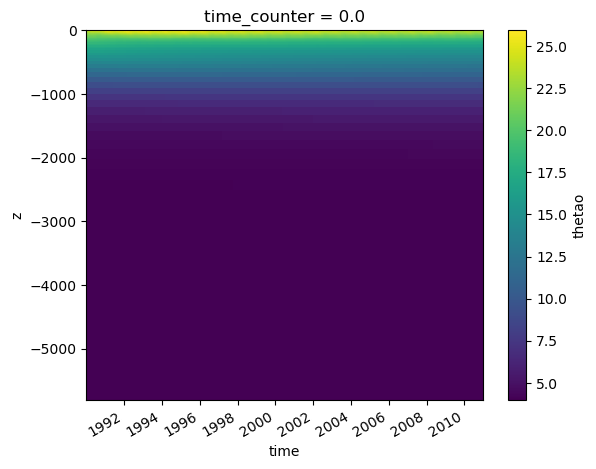

In [11]:
data.coords['z'] = -data['z']
data.thetao.weighted(area).mean(dim=['y', 'x']).plot(x='time',y='z', ylim=[-5800,0])

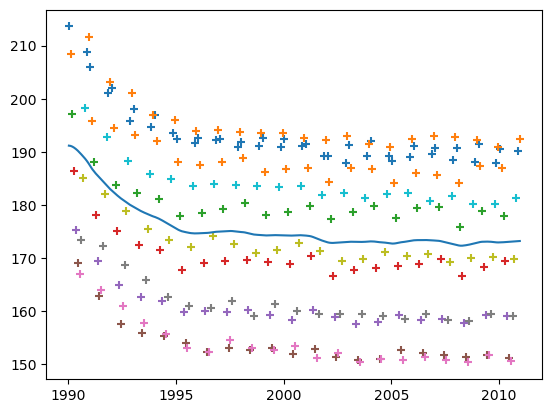

In [23]:
#xdata = data.time
#ydata = 
#data.qsr_oce.weighted(area).mean(dim=['y', 'x']).plot()
xdata = data.time
ydata = data.qsr_oce.weighted(area).mean(dim=['y', 'x'])
for tm in range(12):
    d1 = pd.to_datetime(xdata.values)
    x1 = [yearFraction(t) for t in d1]
    d0 = pd.to_datetime(xdata.where(data['time.month']==tm+1,drop=True).values)
    x0 = [yearFraction(t) for t in d0]
    y0 = ydata.where(data['time.month']==tm+1,drop=True).values
    x1 = np.array(x1)
    x0 = np.array(x0)
    y0 = np.array(y0.flatten())
    if (tm==0):
        y1 = np.interp(x1, x0, y0)
    else:
        y1 = y1 + np.interp(x1, x0, y0)
    plt.scatter(x0,y0,marker='+')
y1 = y1/12
plt.plot(x1,y1)
#ydata1 = remove_seasonal_cycle(xdata, ydata)
#plt.plot(xdata.values,ydata1)